In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

## Find all files

In [3]:
from glob import glob

In [4]:
#files_loc = "/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/toy_sim/si-mu-lator/out_files/"
files_loc = "/Users/willocq/ATLAS/muons4ML/si-mu-lator/run/"

In [5]:
files_nobkg = glob(files_loc+'*_bkg0_*.h5')
#files_bkg = glob(files_loc+'*bkg1*.h5')
files_bkg = glob(files_loc+'nsw_xy_n10k_b1_*.h5')

## Open one file

In [6]:
f5 = h5py.File( files_bkg[0], 'r' )

In [7]:
f5.keys()

<KeysViewHDF5 ['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'signal_keys', 'signals']>

### File structure

The file is structured as follows:

- Each row is an event (a full readout of the detector module within a given time window specified in the detector card)
- For each event, you have the truth information of the one incoming muon (if there is one, specified in the file production step)
- For each event, you have a set of signal readouts

The arrays in the file are:
- 'ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y': muon truth
- 'ev_n_mu_signals', 'ev_n_signals': number of signals that were left by a muon, number of total signals
- 'signal_keys': array of names of signal variables
- 'signals': array of signals

#### The signals array corresponds to the output of the `get_info_wrt_plane` function in class `Signal`:
```
           hit_dict = {'is_muon': self.is_muon,
                    'x': self.x,
                    'y': self.y,
                    'z': plane.z,
                    'ptype': plane.p_type.asint(),
                    'ptilt': plane.tilt,
                    'poffset': plane.offset,
                    'time': self.time,
                    'projX_at_rightend_x': float(x_rightend.x),
                    'projX_at_rightend_y': float(x_rightend.y),
                    'projX_at_middle_x': float(x_middle.x),
                    'projX_at_middle_y': float(x_middle.y),
                    'projY_at_topend_x': float(y_topend.x),
                    'projY_at_topend_y': float(y_topend.y),
                    'projY_at_middle_x': float(y_middle.x),
                    'projY_at_middle_y': float(y_middle.y),
                    'seg_ix': self.seg_ix,
                    'rdrift': self.rdrift
                   }

```

In [8]:
sig_vars = [  'is_muon',
                   'x',
                   'y',
                   'z',
                   'ptype',
                   'ptilt',
                   'poffset',
                   'time',
                   'projX_at_rightend_x',
                   'projX_at_rightend_y',
                   'projX_at_middle_x',
                   'projX_at_middle_y',
                   'projY_at_topend_x',
                   'projY_at_topend_y',
                   'projY_at_middle_x',
                   'projY_at_middle_y',
                   'seg_ix',
                   'rdrift']

### Transform objects in arrays

In [9]:
data = {}
for kk in f5.keys():
    data[kk] = np.array( f5[kk] )

In [10]:
# show first five events
print(
    'mu x', data['ev_mu_x'][:5], '\n',
    'mu theta', data['ev_mu_theta'][:5], '\n',
    'n mu signals', data['ev_n_mu_signals'][:5], '\n',
    'n signals', data['ev_n_signals'][:5], '\n',
)


mu x [ 7.33053129 13.48474914 -2.75894351  6.06439541 -9.255132  ] 
 mu theta [ 0.01184836 -0.0046602  -0.01593503  0.02329442 -0.00464374] 
 n mu signals [12 11 12 11 14] 
 n signals [14 16 15 14 16] 



In [11]:
data['signals'].shape

(10000, 16, 18)

Note that the shape of the signals is, for example, (1000, 39, 18). This means that there are 1000 events, the maximum number of signals in this file is 39, and for each signal there are 18 features.

In [12]:
idx_mu = sig_vars.index('is_muon')
idx_x_inter = sig_vars.index('x')
idx_x_strip = sig_vars.index('projX_at_middle_x')
idx_y_inter = sig_vars.index('y')
idx_z = sig_vars.index('z')
idx_time = sig_vars.index('time')
idx_ptype = sig_vars.index('ptype')

data['signals'][:, :, idx_z].flatten() # show variable z for all signals from all events

array([ 10.5,  15.6,  37.5, ..., 371.5, -99. , -99. ])

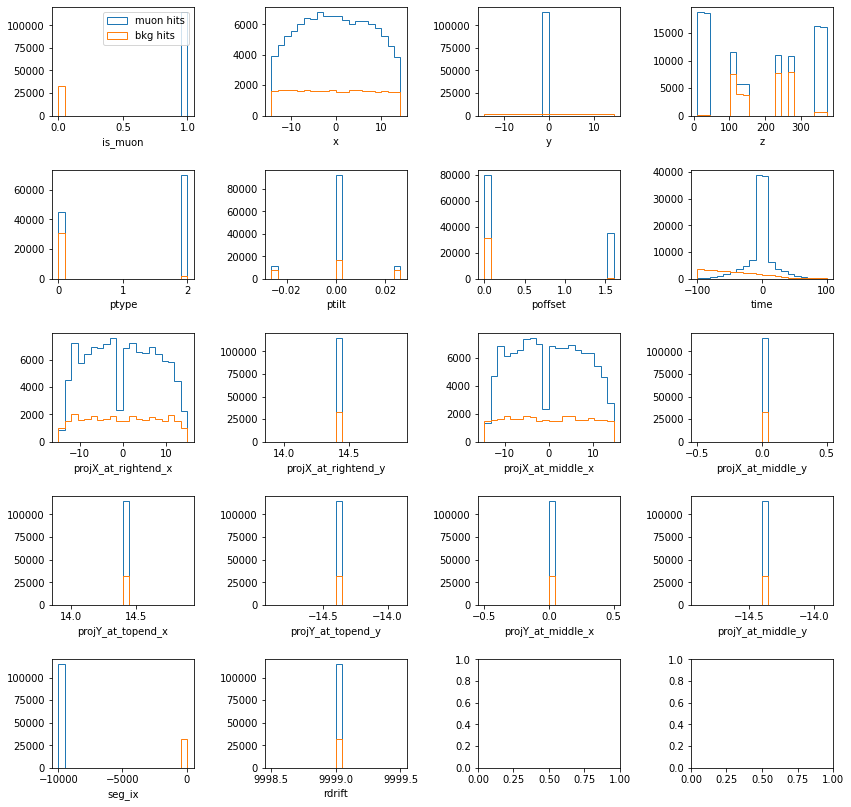

In [13]:
fig, axs = plt.subplots(5, 4, figsize=(14, 14), gridspec_kw={'wspace':0.5, 'hspace': 0.5})
axs = axs.flatten()

mu_hits = data['signals'][:, :, idx_mu].flatten() == 1
empty_hits = data['signals'][:, :, idx_mu].flatten() == -99  # not a signal

for iv in range(data['signals'].shape[2]):
    ivar = data['signals'][:, :, iv].flatten()
    maxvar = np.max( ivar[(~empty_hits)] )
    minvar = np.min( ivar[(~empty_hits)] )
    
    axs[iv].hist( ivar[(mu_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=20, label='muon hits' )
    axs[iv].hist( ivar[(~mu_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=20, label='bkg hits' )
    
    axs[iv].set_xlabel(sig_vars[iv])

axs[0].legend()
plt.show()
    

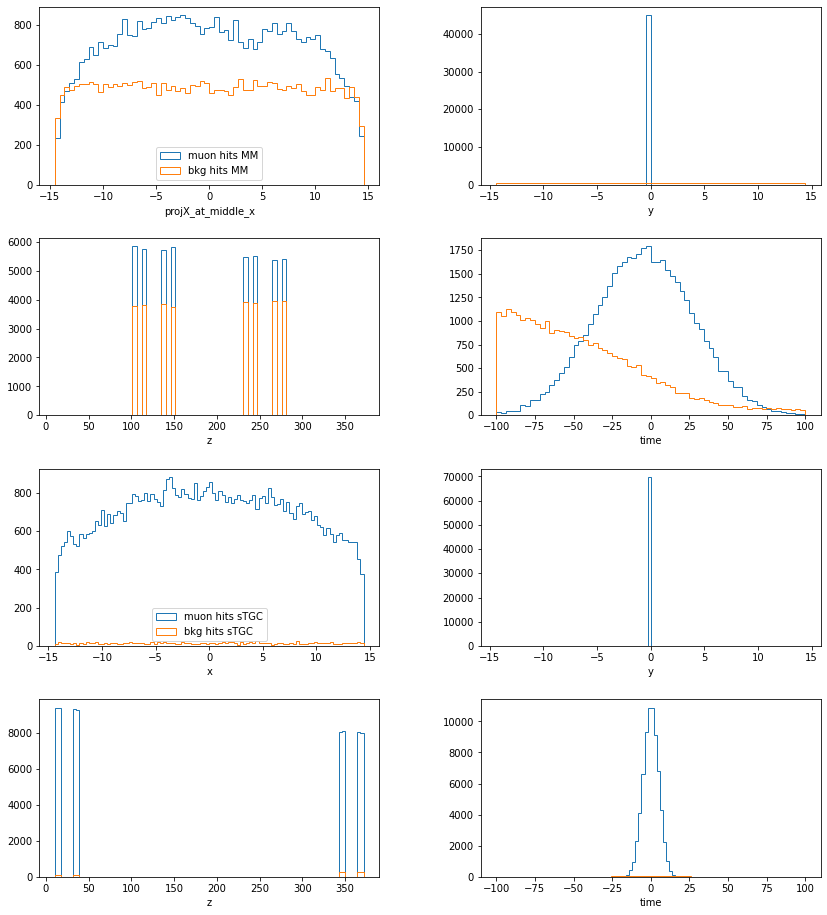

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(14, 16), gridspec_kw={'wspace':0.3, 'hspace': 0.3})
axs = axs.flatten()

iv_pos = [idx_x_strip, idx_y_inter, idx_z, idx_time, idx_x_inter, idx_y_inter, idx_z, idx_time]
mm_hits = data['signals'][:, :, idx_ptype].flatten() == 0
stgc_hits = data['signals'][:, :, idx_ptype].flatten() == 2

# MicroMegas and sTGC hit positions
for i,iv in enumerate(iv_pos):
    ivar = data['signals'][:, :, iv].flatten()
    maxvar = np.max( ivar[(~empty_hits)] )
    minvar = np.min( ivar[(~empty_hits)] )
    
    if i < 4:  # MM hits
        axs[i].hist( ivar[(mu_hits)&(mm_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=64, label='muon hits MM' )
        axs[i].hist( ivar[(~mu_hits)&(mm_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=64, label='bkg hits MM' )
    else:  # sTGC hits    
        axs[i].hist( ivar[(mu_hits)&(stgc_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=100, label='muon hits sTGC' )
        axs[i].hist( ivar[(~mu_hits)&(stgc_hits)&(~empty_hits)], histtype='step', range=(minvar, maxvar), bins=100, label='bkg hits sTGC' )
        
    axs[i].set_xlabel(sig_vars[iv])

axs[0].legend(loc='lower center')
axs[4].legend(loc='lower center')
plt.show()

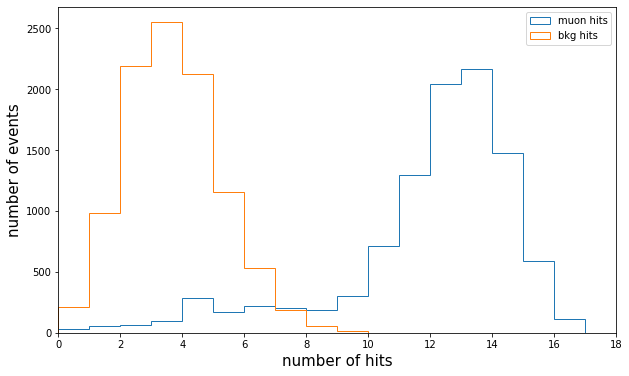

In [15]:
fig = plt.figure(figsize=(10, 6))
xmax = 18

plt.hist( data['ev_n_mu_signals'][:], histtype='step', range=(0, xmax), bins=xmax, label='muon hits' )
plt.hist( data['ev_n_signals'][:]-data['ev_n_mu_signals'][:], histtype='step', range=(0, xmax), bins=xmax, label='bkg hits' )
plt.legend(fontsize = 'large')

plt.xlabel('number of hits', fontsize=15)
plt.ylabel('number of events', fontsize=15)
plt.xlim(0, xmax)

plt.legend()
plt.show()